In [2]:
import pairtools
import os
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np
import pandas as pd

# Hack in gzip path

In [3]:
import os
environment_name = 'NGStest'
environment_path = f"/users/michael.mitter/.conda/envs/{ environment_name }/bin/"

# get pre-set PATH environment variable
original_os_path = os.environ.get('PATH')
os_path = original_os_path

# guard PATH against multiple prepending
if environment_path not in original_os_path:
    os_path = environment_path + ':' + original_os_path
%env PATH=$os_path

#print the PATH to pbgzip with shutil
#import shutil
#print(shutil.which("pbgzip"))

env: PATH=/users/michael.mitter/.conda/envs/NGStest/bin/:/software/2020/software/anaconda3/2019.03/bin;/software/2020/software/anaconda3/2019.03/condabin;/software/2020/software/anaconda3/2019.03/library/bin;/software/2020/software/anaconda3/2019.03/bin;/software/2020/software/anaconda3/2019.03/condabin;/software/2020/software/anaconda3/2019.03/library/bin;/software/2020/software/anaconda3/2019.03/bin;/software/2020/software/anaconda3/2019.03/condabin;/software/2020/software/anaconda3/2019.03/library/bin;/users/michael.mitter/.vscode-server/bin/5763d909d5f12fe19f215cbfdd29a91c0fa9208a/bin:/users/michael.mitter/.conda/envs/gitEnv/bin/:/users/michael.mitter/.vscode-server/bin/5763d909d5f12fe19f215cbfdd29a91c0fa9208a/bin:/software/2020/software/anaconda3/2019.03/condabin:/users/michael.mitter/.conda/envs/gitEnv/bin/:/software/system/utils:/usr/local/bin:/usr/bin:/groups/gerlich/members/MichaelMitter/UCSC_usertools/:/groups/gerlich/members/MichaelMitter/PythonPackages/OnTAD/:/usr/local/sbi

# Define functions

In [16]:
def loadPairs(path):
    header, pairs_body = pairtools._headerops.get_header(
        pairtools._fileio.auto_open(path, 'r'))
    cols = pairtools._headerops.extract_column_names(header)
    frame = pd.read_csv(pairs_body, sep="\t", names=cols)
    return frame

def filterPairs(pairsDf):
    """Helper function to perform filtering
    of pairs that are separated by more than 10kb,
    are on the same chromosome and exhibit the proper
    strandedness for sister-specific contacts.
    Returns percentage of trans-sister contacts."""
    # filter on 10kb distance and same chromosome
    filt1 = {}
    for barcode in pairsDf:
        filt1[barcode] = {pType: frame.loc[(frame["chrom1"] == frame["chrom2"]) &
                                        ((frame["pos2"] - frame["pos1"]) > 10000), :]
                        for pType, frame in pairsDf[barcode].items()}
    # filter on proper strandedness
    filt2 = {}
    for barcode in filt1:
        filt2[barcode] = {}
        for key, value in filt1[barcode].items():
            if key == "trans":
                filt2[barcode]["trans"] = value.loc[value["strand1"] == value["strand2"], :]
            else:
                filt2[barcode]["cis"] = value.loc[value["strand1"] != value["strand2"], :]
    # calculate percentage
    perc = {}
    for barcode in filt2:
        perc[barcode] = len(filt2[barcode]["trans"])/(len(filt2[barcode]["trans"]) + len(filt2[barcode]["cis"]))
    return perc


# Load in files

In [5]:
pairDir1 = "/groups/gerlich/experiments/Experiments_004600/004615/Sequencing_data/Novaseq/pairs"
pairDir2 = "/groups/gerlich/experiments/Experiments_004600/004605/Sequencing_data_Novaseq/Sam"
pairDir3 = "/groups/gerlich/experiments/Experiments_004600/004638/Sequencing_data/nf-output/s4t_merged_pairsam"

# load in data rep1

BARCODES = ["GTGAAA", "GTTTCG", "CGTACG"]

sampleMapping1 = {"GTGAAA": "G2",
                  "GTTTCG": "Prometaphase",
                  "CGTACG": "ON Thymidine"}

pairsRep1 = {}

for barcode in sampleMapping1:
    pairsRep1[sampleMapping1[barcode]] = {pType:  loadPairs(os.path.join(pairDir1, f"{barcode}.{pType}.pairs.gz"))
                                          for pType in ["cis", "trans"]}

# load in data rep2

dirMapping = {"GCCAAT": pairDir2,
              "CAGATC_S8": pairDir3,
              "ACTTGA_S9": pairDir3}

sampleMapping2 = {"GCCAAT": "G2",
                  "CAGATC_S8": "Prometaphase",
                  "ACTTGA_S9": "ON Thymidine"}

pairsRep2 = {}

for barcode in sampleMapping2:
    pairsRep2[sampleMapping2[barcode]] = {pType: loadPairs(os.path.join(dirMapping[barcode], f"{barcode}.{pType}.pairs.gz"))
                                          for pType in ["cis", "trans"]}

# Merge the two replicates

In [6]:
pairs = {}
for barcode in pairsRep2.keys():
    pairs[barcode] = {}
    pairs[barcode]["cis"] = pd.concat((pairsRep1[barcode]["cis"], pairsRep2[barcode]["cis"]))
    pairs[barcode]["trans"] = pd.concat((pairsRep1[barcode]["trans"], pairsRep2[barcode]["trans"]))

# Filter reads and construct dataframe for plotting

In [17]:
finFrame = pd.DataFrame(filterPairs(pairs), index=[0]).transpose().reset_index()
finFrame.columns = ["Condition", "values"]

# Plot result

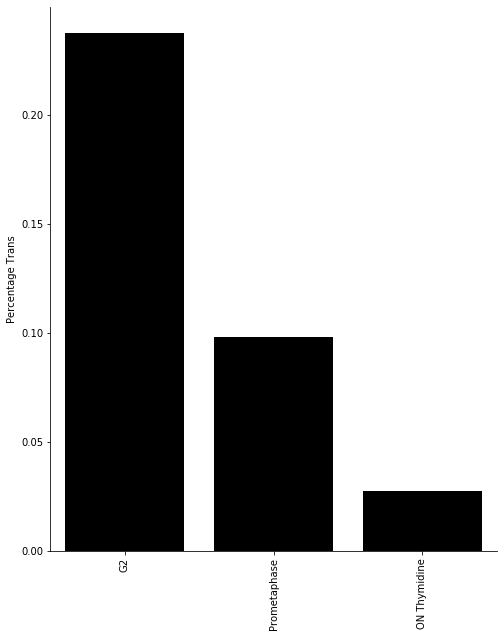

In [18]:
f, ax = plt.subplots()
sbn.barplot(x="Condition", y="values", data=finFrame, ax=ax, color="black")
ax.set_xlabel("")
ax.set_ylabel("Percentage Trans")
sbn.despine()
locs, labels = plt.xticks()
plt.xticks(locs, labels, rotation=90)
f.set_size_inches(8, 10)
plt.show()

# Plot individual points on top of barplot

In [19]:
frame1 = pd.DataFrame(filterPairs(pairsRep1), index=[0]).transpose().reset_index()

In [20]:
frame2 = pd.DataFrame(filterPairs(pairsRep2), index=[0]).transpose().reset_index()

In [21]:
frame1.columns = ["Condition", "values"]
frame2.columns = ["Condition", "values"]

In [22]:
finFrameInd = pd.concat((frame1, frame2))

## set plotting parameters

In [23]:
import matplotlib
matplotlib.rcParams.update({"pdf.fonttype":42})

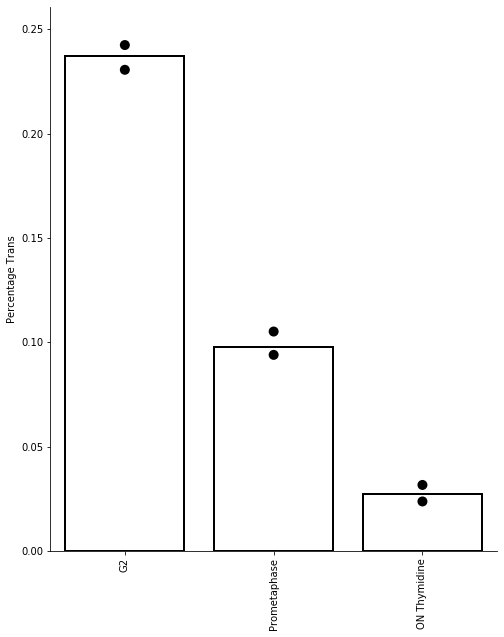

In [24]:
f, ax = plt.subplots()
sbn.barplot(x="Condition", y="values", data=finFrame, ax=ax, color="black",facecolor=(1, 1, 1, 0) , linewidth=2,edgecolor="black")
sbn.stripplot(x="Condition", y="values", data=finFrameInd, color="black", size=10, jitter=0, ax=ax)
ax.set_xlabel("")
ax.set_ylabel("Percentage Trans")
sbn.despine()
plt.xticks(*plt.xticks(), rotation=90)
sbn.despine()
f.set_size_inches(8, 10)
plt.show()

In [25]:
resultdir = "/groups/gerlich/experiments/Experiments_004700/004727/Results/"
f.savefig("Perc_trans_wReplicates.png", bbox_inches="tight")
f.savefig("Perc_trans_wReplicates.pdf", bbox_inches="tight")